# 数据读入

In [8]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torchvision
from torchvision import datasets
from PIL import Image
from torch.utils.data import Dataset

In [6]:
class MyDataset(Dataset):
    def __init__(self, data_dir, info_csv, image_list, transform=None):
        """
        Args:
            data_dir: path to image directory.
            info_csv: path to the csv file containing image indexes
                with corresponding labels.
            image_list: path to the txt file contains image names to training/validation set
            transform: optional transform to be applied on a sample.
        """
        label_info = pd.read_csv(info_csv)
        image_file = open(image_list).readlines()
        self.data_dir = data_dir
        self.image_file = image_file
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_file[index].strip('\n')
        raw_label = self.label_info.loc[self.label_info['Image_index'] == image_name]
        label = raw_label.iloc[:,0]
        image_name = os.path.join(self.data_dir, image_name)
        image = Image.open(image_name).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_file)

# 模型构建

In [10]:
class MLP(torch.nn.Module):
      # 声明带有模型参数的层，这里声明了两个全连接层
  def __init__(self, **kwargs):
    # 调用MLP父类Block的构造函数来进行必要的初始化。这样在构造实例时还可以指定其他函数
    super(MLP, self).__init__(**kwargs)
    self.hidden = torch.nn.Linear(784, 256)
    self.activation = torch.nn.ReLU()
    self.output = torch.nn.Linear(256,10)
    
   # 定义模型的前向计算，即如何根据输入x计算返回所需要的模型输出
  def forward(self, x):
    o = self.activation(self.hidden(x))
    return self.output(o)   

In [11]:
X = torch.rand(2,784)
net = MLP()
print(net)
net(X)

MLP(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (act): ReLU()
  (output): Linear(in_features=256, out_features=10, bias=True)
)


tensor([[-0.1382,  0.1880, -0.1514, -0.1725, -0.1281,  0.0282, -0.1136,  0.1002,
          0.2495,  0.0147],
        [-0.0099,  0.0690, -0.1866, -0.2335, -0.0576, -0.1825, -0.1785,  0.1205,
          0.1481,  0.0777]], grad_fn=<AddmmBackward0>)

## 常见层

In [12]:
## 不含模型参数的层
class MyLayer(torch.nn.Module):
    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
    def forward(self, x):
        return x - x.mean() 

In [13]:
layer = MyLayer()
layer(torch.tensor([1, 2, 3, 4, 5], dtype=torch.float))

tensor([-2., -1.,  0.,  1.,  2.])

In [14]:
## 含模型参数的层
class MyListDense(torch.nn.Module):
    def __init__(self):
        super(MyListDense, self).__init__()
        self.params = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(4, 4)) for i in range(3)])
        self.params.append(torch.nn.Parameter(torch.randn(4, 1)))

    def forward(self, x):
        for i in range(len(self.params)):
            x = torch.mm(x, self.params[i])    ## torch.mm是两个矩阵相乘，即两个二维的张量相乘
        return x
net = MyListDense()
print(net)

MyListDense(
  (params): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 4x4]
      (1): Parameter containing: [torch.FloatTensor of size 4x4]
      (2): Parameter containing: [torch.FloatTensor of size 4x4]
      (3): Parameter containing: [torch.FloatTensor of size 4x1]
  )
)


In [15]:
class MyDictDense(torch.nn.Module):
    def __init__(self):
        super(MyDictDense, self).__init__()
        self.params = torch.nn.ParameterDict({
                'linear1': torch.nn.Parameter(torch.randn(4, 4)),
                'linear2': torch.nn.Parameter(torch.randn(4, 1))
        })
        self.params.update({'linear3': torch.nn.Parameter(torch.randn(4, 2))}) # 新增

    def forward(self, x, choice='linear1'):
        return torch.mm(x, self.params[choice])

net = MyDictDense()
print(net)

MyDictDense(
  (params): ParameterDict(
      (linear1): Parameter containing: [torch.FloatTensor of size 4x4]
      (linear2): Parameter containing: [torch.FloatTensor of size 4x1]
      (linear3): Parameter containing: [torch.FloatTensor of size 4x2]
  )
)


In [16]:
# 卷积运算（二维互相关）
def corr2d(X, K): 
    h, w = K.shape
    X, K = X.float(), K.float()
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

# 二维卷积层
class Conv2D(torch.nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = torch.nn.Parameter(torch.randn(kernel_size))
        self.bias = torch.nn.Parameter(torch.randn(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [17]:
# 定义一个函数来计算卷积层。它对输入和输出做相应的升维和降维
def comp_conv2d(conv2d, X):
    # (1, 1)代表批量大小和通道数
    X = X.view((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.view(Y.shape[2:]) # 排除不关心的前两维:批量和通道

In [19]:
conv2d = torch.nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
X = torch.rand(8, 8)
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

In [20]:
## 池化层
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [21]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]], dtype=torch.float)
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

# 模型示例

In [50]:
class LeNet(torch.nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        # 输入图像channel：1；输出channel：6；5x5卷积核
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # 2x2 Max pooling
        x = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv1(x)), (2, 2))
        # 如果是方阵,则可以只使用一个数字进行定义
        x = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # 除去批处理维度的其他所有维度
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [33]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1的权重

10
torch.Size([6, 1, 5, 5])


In [51]:
input = torch.randn((1, 1, 32, 32), dtype=torch.float32)
out = net(input)
print(out)

tensor([[ 0.0899, -0.0449,  0.0404, -0.0582,  0.0121, -0.0321, -0.0515, -0.1379,
          0.0067,  0.0130]], grad_fn=<AddmmBackward0>)


In [52]:
net.zero_grad()
out.backward(torch.randn(1, 10))

# 模型初始化

In [53]:
## 随机初始化
conv = torch.nn.Conv2d(1,3,3)
linear = torch.nn.Linear(10,1)

In [54]:
# 查看随机初始化的conv参数
conv.weight.data
# 查看linear的参数
linear.weight.data

tensor([[-0.2208,  0.0873, -0.2846,  0.2538, -0.0927,  0.2229,  0.1772,  0.2948,
          0.0576, -0.2700]])

In [55]:
torch.nn.init.kaiming_normal_(conv.weight.data)
conv.weight.data

tensor([[[[ 0.2132, -0.0229, -0.0207],
          [-0.3492, -0.7208,  0.0587],
          [-0.0481,  0.4208,  0.1236]]],


        [[[ 0.3960,  0.6066, -0.2484],
          [ 0.1723,  0.4524, -0.1630],
          [ 0.4282, -0.7684, -0.2818]]],


        [[[-0.3068, -0.1742, -0.4688],
          [ 0.2532, -0.2982, -0.3573],
          [-0.5436, -0.4671, -0.3889]]]])

In [56]:
torch.nn.init.constant_(linear.weight.data,0.3)
linear.weight.data

tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000]])

## 初始化函数的封装

In [61]:
def initialize_weights(self):
    for m in self.modules():
		# 判断是否属于Conv2d
        if isinstance(m, torch.nn.Conv2d):     ## 通常使用isinstance来进行判断模块
            torch.nn.init.xavier_normal_(m.weight.data)
			# 判断是否有偏置
            if m.bias is not None:
                torch.nn.init.constant_(m.bias.data,0.3)
        elif isinstance(m, torch.nn.Linear):
            torch.nn.init.normal_(m.weight.data, 0.1)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias.data)
        elif isinstance(m, torch.nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zeros_()	

In [62]:
# 模型的定义
class MLP(torch.nn.Module):
  # 声明带有模型参数的层，这里声明了两个全连接层
  def __init__(self, **kwargs):
    # 调用MLP父类Block的构造函数来进行必要的初始化。这样在构造实例时还可以指定其他函数
    super(MLP, self).__init__(**kwargs)
    self.hidden = torch.nn.Conv2d(1,1,3)
    self.act = torch.nn.ReLU()
    self.output = torch.nn.Linear(10,1)
    
   # 定义模型的前向计算，即如何根据输入x计算返回所需要的模型输出
  def forward(self, x):
    o = self.act(self.hidden(x))
    return self.output(o)

mlp = MLP()
print(list(mlp.parameters()))
print("-------初始化-------")

initialize_weights(mlp)
print(list(mlp.parameters()))

[Parameter containing:
tensor([[[[ 0.1168,  0.0915, -0.1900],
          [-0.2221, -0.0107,  0.1153],
          [-0.3275, -0.1296,  0.3117]]]], requires_grad=True), Parameter containing:
tensor([0.0806], requires_grad=True), Parameter containing:
tensor([[-0.2741,  0.0491,  0.2559, -0.2027,  0.0238,  0.2721,  0.2606, -0.2879,
          0.2441,  0.1189]], requires_grad=True), Parameter containing:
tensor([0.0263], requires_grad=True)]
-------初始化-------
[Parameter containing:
tensor([[[[ 0.4471,  0.2237,  0.1045],
          [ 0.1153, -0.1314, -0.3274],
          [-0.4388,  0.3325, -0.1100]]]], requires_grad=True), Parameter containing:
tensor([0.3000], requires_grad=True), Parameter containing:
tensor([[ 0.5033,  1.4954, -0.6214, -0.0831, -0.0945,  0.5557, -2.4865, -0.3636,
         -1.6572,  0.0210]], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True)]


# 损失函数

In [64]:
m = torch.nn.Sigmoid()
loss = torch.nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
output.backward()
print('BCELoss损失函数的计算结果为',output)

BCELoss损失函数的计算结果为 tensor(0.6753, grad_fn=<BinaryCrossEntropyBackward0>)


In [65]:
loss = torch.nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
print('CrossEntropyLoss损失函数的计算结果为',output)

CrossEntropyLoss损失函数的计算结果为 tensor(2.4537, grad_fn=<NllLossBackward0>)


In [66]:
loss = torch.nn.L1Loss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()
print('L1损失函数的计算结果为',output)

L1损失函数的计算结果为 tensor(1.3191, grad_fn=<L1LossBackward0>)


In [67]:
loss = torch.nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()
print('MSE损失函数的计算结果为',output)

MSE损失函数的计算结果为 tensor(1.3164, grad_fn=<MseLossBackward0>)


In [68]:
loss = torch.nn.SmoothL1Loss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()
print('SmoothL1Loss损失函数的计算结果为',output)

SmoothL1Loss损失函数的计算结果为 tensor(0.6853, grad_fn=<SmoothL1LossBackward0>)


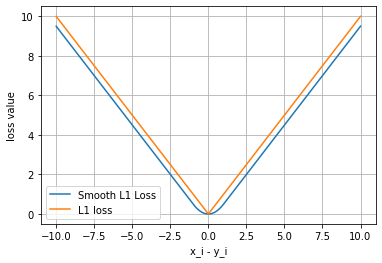

In [69]:
inputs = torch.linspace(-10, 10, steps=5000)
target = torch.zeros_like(inputs)

loss_f_smooth = torch.nn.SmoothL1Loss(reduction='none')
loss_smooth = loss_f_smooth(inputs, target)
loss_f_l1 = torch.nn.L1Loss(reduction='none')
loss_l1 = loss_f_l1(inputs,target)

plt.plot(inputs.numpy(), loss_smooth.numpy(), label='Smooth L1 Loss')
plt.plot(inputs.numpy(), loss_l1, label='L1 loss')
plt.xlabel('x_i - y_i')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()

In [70]:
loss = torch.nn.PoissonNLLLoss()
log_input = torch.randn(5, 2, requires_grad=True)
target = torch.randn(5, 2)
output = loss(log_input, target)
output.backward()
print('PoissonNLLLoss损失函数的计算结果为',output)

PoissonNLLLoss损失函数的计算结果为 tensor(2.1372, grad_fn=<MeanBackward0>)


In [71]:
inputs = torch.tensor([[0.5, 0.3, 0.2], [0.2, 0.3, 0.5]])
target = torch.tensor([[0.9, 0.05, 0.05], [0.1, 0.7, 0.2]], dtype=torch.float)
loss = torch.nn.KLDivLoss()
output = loss(inputs,target)

print('KLDivLoss损失函数的计算结果为',output)

KLDivLoss损失函数的计算结果为 tensor(-0.3335)


D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:2747: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


In [72]:
loss = torch.nn.MarginRankingLoss()
input1 = torch.randn(3, requires_grad=True)
input2 = torch.randn(3, requires_grad=True)
target = torch.randn(3).sign()
output = loss(input1, input2, target)
output.backward()

print('MarginRankingLoss损失函数的计算结果为',output)

MarginRankingLoss损失函数的计算结果为 tensor(0.8093, grad_fn=<MeanBackward0>)


In [73]:
loss = torch.nn.MultiLabelMarginLoss()
x = torch.FloatTensor([[0.9, 0.2, 0.4, 0.8]])
# for target y, only consider labels 3 and 0, not after label -1
y = torch.LongTensor([[3, 0, -1, 1]])# 真实的分类是，第3类和第0类
output = loss(x, y)

print('MultiLabelMarginLoss损失函数的计算结果为',output)

MultiLabelMarginLoss损失函数的计算结果为 tensor(0.4500)


In [74]:
inputs = torch.tensor([[0.3, 0.7], [0.5, 0.5]])  # 两个样本，两个神经元
target = torch.tensor([[-1, 1], [1, -1]], dtype=torch.float)  # 该 loss 为逐个神经元计算，需要为每个神经元单独设置标签

loss_f = torch.nn.SoftMarginLoss()
output = loss_f(inputs, target)

print('SoftMarginLoss损失函数的计算结果为',output)

SoftMarginLoss损失函数的计算结果为 tensor(0.6764)


In [75]:
inputs = torch.tensor([[0.3, 0.7], [0.5, 0.5]]) 
target = torch.tensor([0, 1], dtype=torch.long) 

loss_f = torch.nn.MultiMarginLoss()
output = loss_f(inputs, target)

print('MultiMarginLoss损失函数的计算结果为',output)

MultiMarginLoss损失函数的计算结果为 tensor(0.6000)


In [76]:
triplet_loss = torch.nn.TripletMarginLoss(margin=1.0, p=2)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
output = triplet_loss(anchor, positive, negative)
output.backward()
print('TripletMarginLoss损失函数的计算结果为',output)

TripletMarginLoss损失函数的计算结果为 tensor(1.0314, grad_fn=<MeanBackward0>)


In [77]:
loss_f = torch.nn.HingeEmbeddingLoss()
inputs = torch.tensor([[1., 0.8, 0.5]])
target = torch.tensor([[1, 1, -1]])
output = loss_f(inputs,target)

print('HingEmbeddingLoss损失函数的计算结果为',output)

HingEmbeddingLoss损失函数的计算结果为 tensor(0.7667)


In [79]:
loss_f = torch.nn.CosineEmbeddingLoss()
inputs_1 = torch.tensor([[0.3, 0.5, 0.7], [0.3, 0.5, 0.7]])
inputs_2 = torch.tensor([[0.1, 0.3, 0.5], [0.1, 0.3, 0.5]])
target = torch.tensor([1, -1], dtype=torch.float)
output = loss_f(inputs_1,inputs_2,target)

print('CosineEmbeddingLoss损失函数的计算结果为',output)

CosineEmbeddingLoss损失函数的计算结果为 tensor(0.5000)


In [80]:
# Target are to be padded
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size
S = 30      # Target sequence length of longest target in batch (padding length)
S_min = 10  # Minimum target length, for demonstration purposes

# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()

# Initialize random batch of targets (0 = blank, 1:C = classes)
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)

input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
ctc_loss = torch.nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()


# Target are to be un-padded
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size

# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

# Initialize random batch of targets (0 = blank, 1:C = classes)
target_lengths = torch.randint(low=1, high=T, size=(N,), dtype=torch.long)
target = torch.randint(low=1, high=C, size=(sum(target_lengths),), dtype=torch.long)
ctc_loss = torch.nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()

print('CTCLoss损失函数的计算结果为',loss)

CTCLoss损失函数的计算结果为 tensor(11.5525, grad_fn=<MeanBackward0>)


# 优化器

In [84]:
import os
import torch

# 设置权重，服从正态分布  --> 2 x 2
weight = torch.randn((2, 2), requires_grad=True)
# 设置梯度为全1矩阵  --> 2 x 2
weight.grad = torch.ones((2, 2))
# 输出现有的weight和data
print("The data of weight before step:\n{}".format(weight.data))
print("The grad of weight before step:\n{}".format(weight.grad))
# 实例化优化器
optimizer = torch.optim.SGD([weight], lr=0.1, momentum=0.9)
# 进行一步操作
optimizer.step()
# 查看进行一步后的值，梯度
print("The data of weight after step:\n{}".format(weight.data))
print("The grad of weight after step:\n{}".format(weight.grad))
# 权重清零
optimizer.zero_grad()
# 检验权重是否为0
print("The grad of weight after optimizer.zero_grad():\n{}".format(weight.grad))
# 输出参数
print("optimizer.params_group is \n{}".format(optimizer.param_groups))
# 查看参数位置，optimizer和weight的位置一样，我觉得这里可以参考Python是基于值管理
print("weight in optimizer:{}\nweight in weight:{}\n".format(id(optimizer.param_groups[0]['params'][0]), id(weight)))
# 添加参数：weight2
weight2 = torch.randn((3, 3), requires_grad=True)
optimizer.add_param_group({"params": weight2, 'lr': 0.0001, 'nesterov': True})
# 查看现有的参数
print("optimizer.param_groups is\n{}".format(optimizer.param_groups))
# 查看当前状态信息
opt_state_dict = optimizer.state_dict()
print("state_dict before step:\n", opt_state_dict)
# 进行5次step操作
for _ in range(50):
    optimizer.step()
# 输出现有状态信息
print("state_dict after step:\n", optimizer.state_dict())
# 保存参数信息
torch.save(optimizer.state_dict(),os.path.join(r"Attention_Unet", "optimizer_state_dict.pkl"))
print("----------done-----------")
# 加载参数信息
state_dict = torch.load(r"Attention_Unet\optimizer_state_dict.pkl") # 需要修改为你自己的路径
optimizer.load_state_dict(state_dict)
print("load state_dict successfully\n{}".format(state_dict))
# 输出最后属性信息
print("\n{}".format(optimizer.defaults))
print("\n{}".format(optimizer.state))
print("\n{}".format(optimizer.param_groups))

The data of weight before step:
tensor([[ 0.5512,  0.2066],
        [-0.7554,  0.9012]])
The grad of weight before step:
tensor([[1., 1.],
        [1., 1.]])
The data of weight after step:
tensor([[ 0.4512,  0.1066],
        [-0.8554,  0.8012]])
The grad of weight after step:
tensor([[1., 1.],
        [1., 1.]])
The grad of weight after optimizer.zero_grad():
tensor([[0., 0.],
        [0., 0.]])
optimizer.params_group is 
[{'params': [tensor([[ 0.4512,  0.1066],
        [-0.8554,  0.8012]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}]
weight in optimizer:2599848718064
weight in weight:2599848718064

optimizer.param_groups is
[{'params': [tensor([[ 0.4512,  0.1066],
        [-0.8554,  0.8012]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}, {'params': [tensor([[ 0.0042, -0.5098, -1.4636],
        [-0.1872,  0.1309,  0.8817],
        [-0.7516, -0.5788,  1.9815]], requires